<a href="https://colab.research.google.com/github/imeldp96/qsar-renieramycin/blob/main/ML_QSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Prep

In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame as df
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import LeaveOneOut

from sklearn import linear_model as MLR

from sklearn.ensemble import RandomForestRegressor as RF

from sklearn.svm import SVR

from sklearn.neural_network import MLPRegressor as NN

import xgboost
from xgboost import XGBRegressor as XGB

from sklearn.ensemble import GradientBoostingRegressor as GBR

import seaborn as sns
import matplotlib.pyplot as plt

loo = LeaveOneOut()
random = 42 #random number for consistent results, can be changed to anything

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/data-18032025.csv', index_col=[0])

In [ ]:
X= data.drop(['pIC50'], axis=1)
y = data['pIC50']

In [ ]:
print(X.head())

               G1     G2     G3     G4     G5     G6     G7     G8      G9  \
Structures                                                                   
11a         0.100  0.063 -0.207  0.273 -0.550 -0.476 -0.480 -0.248  0.3115   
11c         0.101  0.065 -0.210  0.275 -0.550 -0.477 -0.481 -0.249  0.3115   
11e         0.100  0.064 -0.209  0.274 -0.550 -0.476 -0.480 -0.241  0.3100   
11g         0.101  0.064 -0.204  0.272 -0.549 -0.479 -0.480 -0.214  0.3130   
11i         0.086  0.060 -0.186  0.262 -0.545 -0.507 -0.529 -0.239  0.3440   

              G10  ...         N97         N98        N99      N100      N101  \
Structures         ...                                                          
11a         0.042  ...   95.544791 -212.052108 -13.566627  0.160816  0.207894   
11c         0.028  ...  137.701557 -299.913990 -15.465638  0.163889  0.211846   
11e         0.042  ...  148.073138 -365.577769 -17.523108  0.144558  0.186885   
11g         0.056  ...  121.534840 -285.764870 -

#FEATURE IMPORTANCE

In [ ]:
X_train_fi = X.iloc[:17]
y_train = y.iloc[:17]

X_test_fi = X.iloc[17:]
y_test = y.iloc[17:]

In [ ]:
rf = RF(random_state=random)
model_rf = rf.fit(X_train_fi, y_train)
y_train_pred = model_rf.predict(X_train_fi)

In [ ]:
# Training model evaluation
print('The training r_sq is: %.3f' % model_rf.score(X_train_fi, y_train))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('The MAE is: %.3f' % mean_absolute_error(y_train, y_train_pred))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_train, y_train_pred))

The training r_sq is: 0.834
The RMSE is: 0.143
The MAE is: 0.117
The MAPE is: 0.023


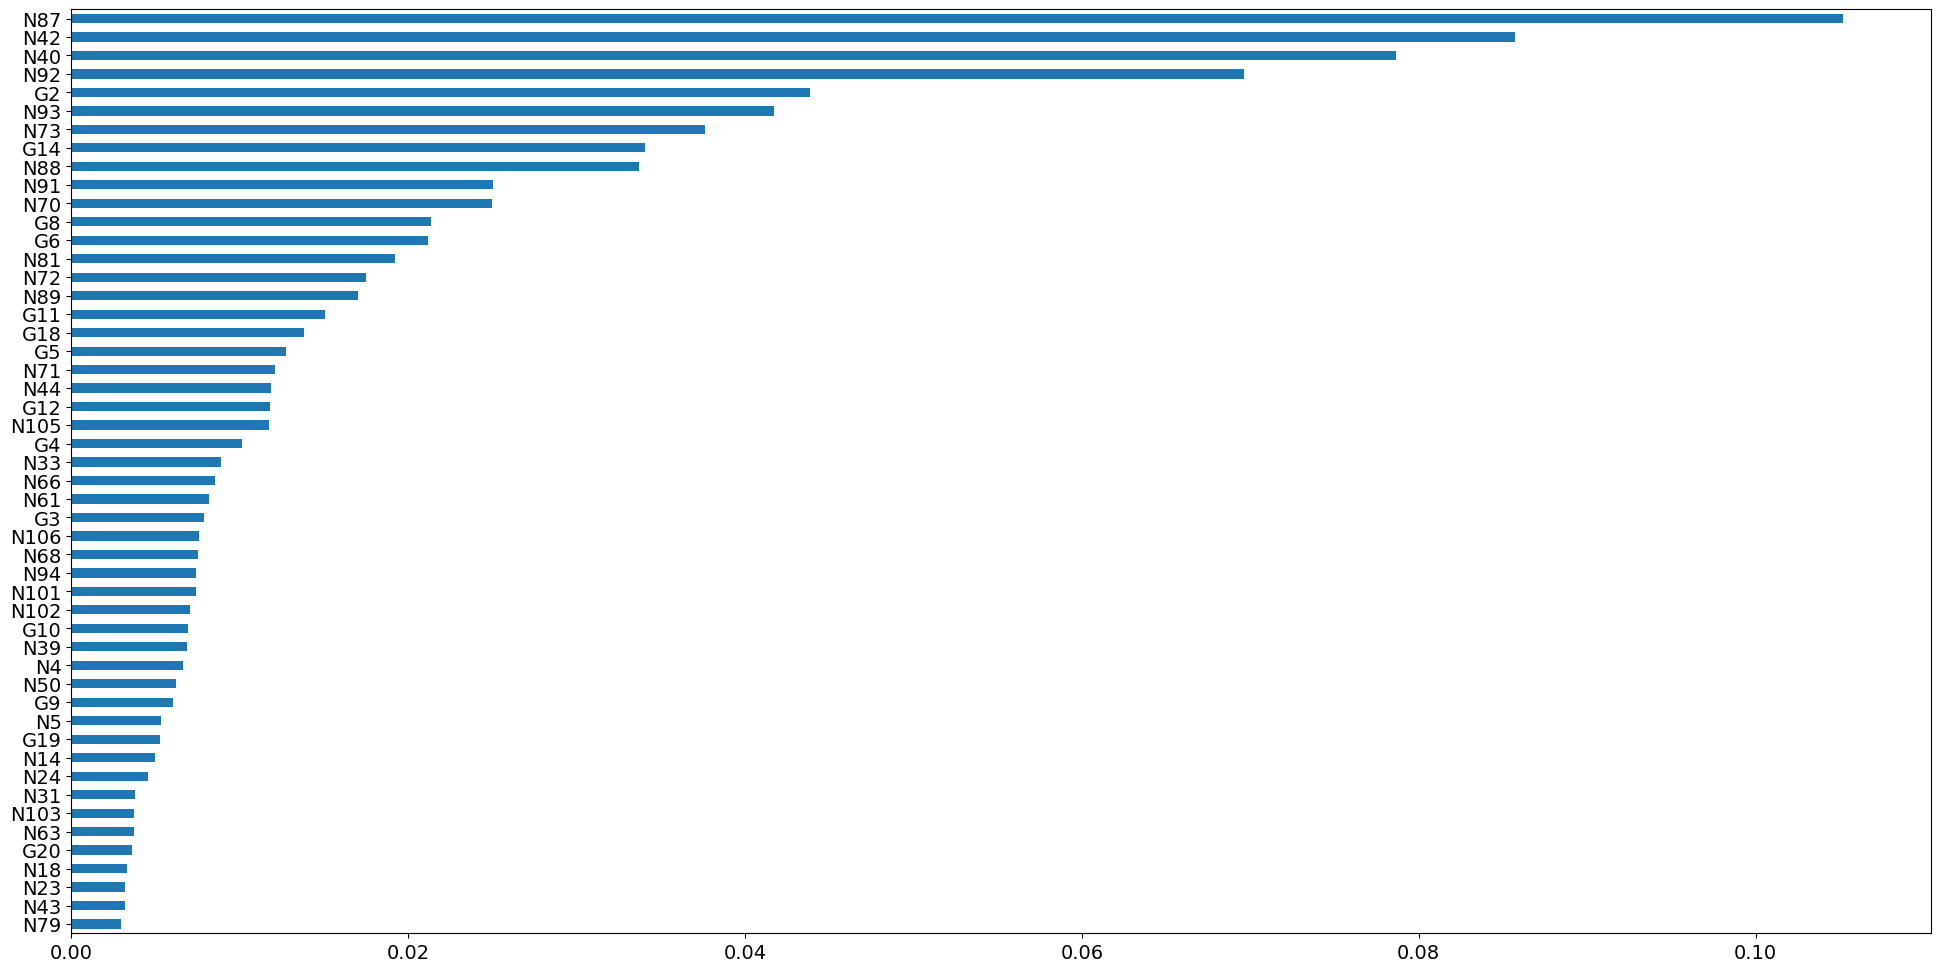

In [ ]:
# Select top 50 features
model_ranks=pd.Series(rf.feature_importances_,index=X_train_fi.columns,name="Importance").sort_values(ascending=True,inplace=False)
top_n = 50
top_features = model_ranks[-top_n:]
ax=top_features.plot(kind='barh', fontsize=14,
                     figsize = (24, 12))

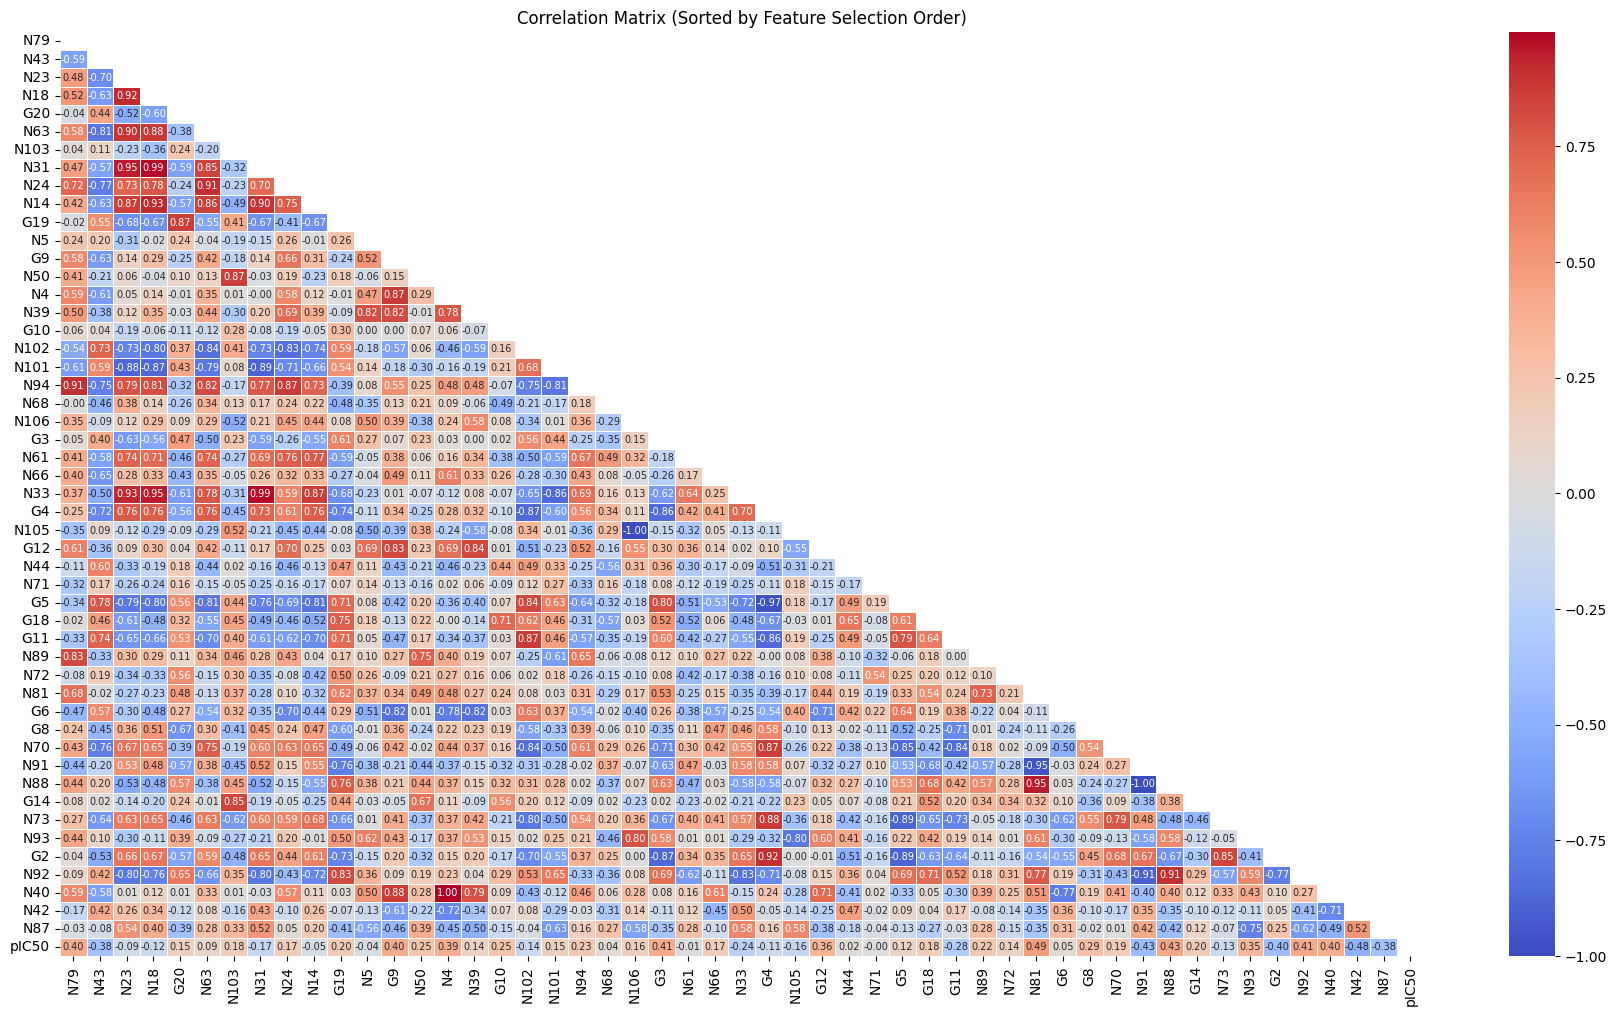

In [ ]:
# Reorder columns in X_train_fil and y_train according to top_features.index
X_train_fil = X_train_fi[top_features.index]  # this should match top_features.index if same
df = X_train_fil.copy()
df['pIC50'] = y_train

# Reorder the correlation matrix
ordered_columns = list(top_features.index) + ['pIC50']
corr_matrix = df[ordered_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f", annot_kws={"size": 7})
plt.title('Correlation Matrix (Sorted by Feature Selection Order)')
plt.show()


In [ ]:
X_train = X_train_fi[['N87', 'N42', 'N40']]
y_train = y.iloc[:17]

X_test = X_test_fi[['N87', 'N42', 'N40']]
y_test = y.iloc[17:]

#RANDOM FOREST

Hyperparameters Tuning

In [ ]:
def objective(n_estimators, min_samples_split, min_samples_leaf, bootstrap):
    model = RF(n_estimators=int(n_estimators),
               min_samples_split=int(min_samples_split),
               min_samples_leaf=int(min_samples_leaf),
               bootstrap=bool(round(bootstrap)),
               random_state=random, n_jobs=-1, max_features=None)
    return np.mean(cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=loo, n_jobs=-1))

In [ ]:
#Bounds for hyperparameters
param_bounds = {
    'n_estimators' : (2, 500), #max number can be changed accordingly. but 500 is usually enough
    'min_samples_split': (2, 17), #max number equals to the number of training set
    'min_samples_leaf' : (1,17), #max number equals to the number of training set
    'bootstrap' : (0,1)
}

optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=random)
optimizer.probe(params={'bootstrap': True,'min_samples_leaf': 1,'min_samples_split': 2, 'n_estimators': 100}, lazy=True)
optimizer.maximize(init_points=5, n_iter=500)

In [ ]:
best_params = optimizer.max['params']
best_params_formatted = {
    'n_estimators': int(best_params['n_estimators']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf']),
    'bootstrap': bool(best_params['bootstrap'])
}

Model Fitting

In [ ]:
model_rf = RF(**best_params_formatted, random_state=random)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, min_samples_split=5, n_estimators=460,
                      random_state=42)

In [ ]:
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

In [ ]:
# Training model evaluation
print('The training r_sq is: %.3f' % model_rf.score(X_train, y_train))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred_rf)))
print('The MAE is: %.3f' % mean_absolute_error(y_train, y_train_pred_rf))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_train, y_train_pred_rf))

The training r_sq is: 0.948
The RMSE is: 0.080
The MAE is: 0.063
The MAPE is: 0.012


In [ ]:
# Test model evaluation
print('The test r_sq is: %.3f' % r2_score(y_test, y_test_pred_rf))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print('The MAE is: %.3f' % mean_absolute_error(y_test, y_test_pred_rf))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_test, y_test_pred_rf))

The test r_sq is: 0.901
The RMSE is: 0.125
The MAE is: 0.095
The MAPE is: 0.019


In [ ]:
df_ytrain_rf = pd.DataFrame(y_train_pred_rf, columns=['pIC50'])
df_ytest_rf = pd.DataFrame(y_test_pred_rf, columns=['pIC50'])

df_pred_rf = pd.concat([df_ytrain_rf, df_ytest_rf], axis=0)
print(df_pred_rf)

      pIC50
0   4.59925
1   4.59925
2   4.59925
3   4.79650
4   4.90350
5   4.59925
6   5.16450
7   5.50275
8   5.16450
9   5.50275
10  4.79650
11  4.64300
12  4.90350
13  4.79650
14  4.79650
15  5.50275
16  5.50275
0   4.59925
1   5.50275
2   5.50275
3   4.79650
4   5.50275


#SVR

Hyperparameter Tuning

In [ ]:
#For SVR, the dataset need to be normalized first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def objective(C, epsilon, kernel, degree):
    kernel = ['linear', 'rbf', 'poly'][int(kernel)]
    if kernel == 'poly':
        model = SVR(C=float(C), epsilon=float(epsilon), kernel=kernel, degree=int(degree), cache_size=1000)
    else:
        model = SVR(C=float(C), epsilon=float(epsilon), kernel=kernel, cache_size=1000)
    return np.mean(cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=loo, n_jobs=-1))

# Bounds for hyperparameters
param_bounds = {
    'C': (0.1, 250), # the minimum can be smaller than 0.1, but cannot be negative; the maximum can be larger than 250 as well
    'epsilon': (0.0, 1.0), #from 0 to 1
    'kernel': (1, 2),  # 0: 'linear', 1: 'rbf', 2: 'poly'
    'degree': (3, 20)  # Only relevant if kernel is 'poly'
}

In [ ]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.probe({'C': 1.0, 'epsilon': 0.1, 'degree':3, 'kernel': 1}, lazy=True)
optimizer.maximize(init_points=20, n_iter=500)

In [ ]:
# Extract best parameters
best_params = optimizer.max['params']

# Convert kernel parameter back to string
best_kernel = ['linear', 'rbf', 'poly'][int(best_params['kernel'])]
if best_kernel == 'poly':
    optimized_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_kernel, degree=int(best_params['degree']))
else:
    optimized_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_kernel)

Model Fitting

In [ ]:
model_svr = SVR(**best_params_formatted, random_state=random)
model_svr.fit(X_train_scaled, y_train)

In [ ]:
y_train_pred_svr = model_svr.predict(X_train_scaled)
y_test_pred_svr = model_svr.predict(X_test_scaled)

In [ ]:
# Training model evaluation
print('The training r_sq is: %.3f' % model_svr.score(X_train_scaled, y_train))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred_svr)))
print('The MAE is: %.3f' % mean_absolute_error(y_train, y_train_pred_svr))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_train, y_train_pred_svr))

In [ ]:
# Test model evaluation
print('The test r_sq is: %.3f' % r2_score(y_test, y_test_pred_svr))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred_svr)))
print('The MAE is: %.3f' % mean_absolute_error(y_test, y_test_pred_svr))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_test, y_test_pred_svr))

In [ ]:
df_ytrain_svr = pd.DataFrame(y_train_pred_svr, columns=['pIC50'])
df_ytest_svr = pd.DataFrame(y_test_pred_svr, columns=['pIC50'])

df_pred_svr = pd.concat([df_ytrain_svr, df_ytest_svr], axis=0)
print(df_pred_svr)

#GBR

In [ ]:
def objective(n_estimators, max_depth, min_samples_split, learning_rate):
    model = GBR(loss="squared_error",
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                min_samples_leaf=int(min_samples_leaf),
                learning_rate=float(learning_rate)
               )
    return np.mean(cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=loo, n_jobs=-1))

In [ ]:
# Bounds for hyperparameters
param_bounds = {
    'n_estimators' : (2,500), #max number can be changed accordingly. but 500 is usually enough
    'min_samples_split': (2, 17), #max number equals to the number of training set
    'min_samples_leaf' : (1,17), #max number equals to the number of training set
    'learning_rate' : (0.001, 1.0)
     }

optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=random)
optimizer.probe({'n_estimators': 100, 'min_samples_leaf' : 1, 'min_samples_split' : 2, 'learning_rate' : 0.1}, lazy=True)
optimizer.maximize(init_points=5, n_iter=500)

In [ ]:
best_params = optimizer.max['params']
best_params_formatted = {
    'n_estimators': int(best_params['n_estimators']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf']),
    'learning_rate': float(best_params['bootstrap'])
}

Model Fitting

In [ ]:
model_gbr = GBR(**best_params_formatted, random_state=random)
model_gbr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, min_samples_split=5, n_estimators=460,
                      random_state=42)

In [ ]:
y_train_pred_gbr = model_gbr.predict(X_train)
y_test_pred_gbr = model_gbr.predict(X_test)

In [ ]:
# Training model evaluation
print('The training r_sq is: %.3f' % model_rf.score(X_train, y_train))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred_gbr)))
print('The MAE is: %.3f' % mean_absolute_error(y_train, y_train_pred_gbr))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_train, y_train_pred_gbr))

The training r_sq is: 0.948
The RMSE is: 0.080
The MAE is: 0.063
The MAPE is: 0.012


In [ ]:
# Test model evaluation
print('The test r_sq is: %.3f' % r2_score(y_test, y_test_pred_gbr))
print('The RMSE is: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred_gbr)))
print('The MAE is: %.3f' % mean_absolute_error(y_test, y_test_pred_gbr))
print('The MAPE is: %.3f' % mean_absolute_percentage_error(y_test, y_test_pred_gbr))

The test r_sq is: 0.901
The RMSE is: 0.125
The MAE is: 0.095
The MAPE is: 0.019


In [ ]:
df_ytrain_gbr = pd.DataFrame(y_train_pred_gbr, columns=['pIC50'])
df_ytest_gbr = pd.DataFrame(y_test_pred_gbr, columns=['pIC50'])

df_pred_gbr = pd.concat([df_ytrain_gbr, df_ytest_gbr], axis=0)
print(df_pred_gbr)

#SAVING MODELS' RESULTS

In [ ]:
# 1. Set feature names based on your earlier selection
feature_names = ['G7', 'G6', 'G4'] #change accordingly to the features/descriptors that you used

# 2. Create training DataFrame
train_df = pd.DataFrame(X_train, columns=feature_names)
train_df['pIC50_true'] = y_train.values  # Make sure to align values
train_df['pIC50_pred_rf'] = y_train_pred_rf
train_df['pIC50_pred_svr'] = y_train_pred_svr
train_df['pIC50_pred_gbr'] = y_train_pred_gbr
train_df['dataset'] = 'train'

# 3. Create testing DataFrame
test_df = pd.DataFrame(X_test, columns=feature_names)
test_df['pIC50_true'] = y_test.values
test_df['pIC50_pred_rf'] = y_test_pred_rf
test_df['pIC50_pred_svr'] = y_test_pred_svr
test_df['pIC50_pred_gbr'] = y_test_pred_gbr
test_df['dataset'] = 'test'

# 4. Merge
all_df = pd.concat([train_df, test_df], ignore_index=True)

# 5. Order columns nicely
ordered_columns = feature_names + ['pIC50_true', 'pIC50_pred_rf', 'pIC50_pred_svr', 'pIC50_pred_gbr', 'dataset']
all_df = all_df[ordered_columns]

# 6. Save
all_df.to_csv('/content/drive/MyDrive/all_data_predictions.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Function to calculate metrics
def calc_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    r2 = r2_score(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    return r2, rmse_train, rmse_test

# Metrics calculation
metrics_rf = calc_metrics(y_train, y_train_pred_rf, y_test, y_test_pred_rf)
metrics_svr = calc_metrics(y_train, y_train_pred_svr, y_test, y_test_pred_svr)
metrics_gbr = calc_metrics(y_train, y_train_pred_gbr, y_test, y_test_pred_gbr)

# Setup subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Common settings
models = ['RF', 'SVR', 'GBR']
y_train_preds = [y_train_pred_rf, y_train_pred_svr, y_train_pred_gbr]
y_test_preds = [y_test_pred_rf, y_test_pred_svr, y_test_pred_gbr]
metrics = [metrics_rf, metrics_svr, metrics_gbr]

# Plotting
for ax, model, Ytrain_pred, Ytest_pred, metric in zip(axes, models, y_train_preds, y_test_preds, metrics):
    # Plot train set
    ax.scatter(y_train, y_train_pred, color='blue', label='Train', marker='o', edgecolor='k', s=80, alpha=0.9)
    # Plot test set
    ax.scatter(y_test, y_test_pred, color='red', label='Test', marker='s', edgecolor='k', s=80, alpha=0.9)

    # Plot y=x line
    all_true = np.concatenate([y_train, y_test])
    all_pred = np.concatenate([y_train_pred, y_test_pred])
    min_val = min(all_true.min(), all_pred.min())
    max_val = max(all_true.max(), all_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    # Title and labels
    ax.set_title(f'{model} Model', fontsize=14)
    ax.set_xlabel('Experimental pIC$_{50}$', fontsize=12)
    ax.set_ylabel('Predicted pIC$_{50}$', fontsize=12)
    ax.set_xlim(min_val-0.1, max_val+0.1)
    ax.set_ylim(min_val-0.1, max_val+0.1)

    # Inset box with metrics
    inset_text = f"""R² train = {metric[0]:.3f}
RMSE train = {metric[1]:.3f}
RMSE test = {metric[2]:.3f}"""
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, inset_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

# Only one legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.savefig('/content/drive/MyDrive/plot_expvspred.tif', dpi=330, format='tif')
plt.show()
